In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

sns.set_theme("talk")
sns.set_style("whitegrid")

In [3]:
import os

os.chdir("/home/julian/Uni/MasterThesis/code/experiments/05B_CompareSimulation/")

In [4]:
# KNOWn bug in tikzplotlib: https://stackoverflow.com/questions/75900239/attributeerror-occurs-with-tikzplotlib-when-legend-is-plotted
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

In [5]:
python_color = sns.color_palette()[0]
r_color = sns.color_palette()[1]

# R vs Python Results 

In [6]:
# combine python results into one dataframe
import os

results_dir = "results_v4"
dataframes = []
for i, f in enumerate(filter(lambda x: x.startswith("results_py"), os.listdir(results_dir))):
    print("Reading file %s" % i, end="\r")
    dataframes.append(pd.read_csv(os.path.join(results_dir, f)))

results_py = pd.concat(dataframes)
results_py.drop("Unnamed: 0", axis=1, inplace=True)

# add column with ts and ss information
ts_py = results_py['file'].apply(lambda x: re.search(r'_TS(\d+\.\d+)', x).group(1)).astype("float")
ss_py = results_py['file'].apply(lambda x: re.search(r'_SS(\d+\.\d+)', x).group(1)).astype("float")
results_py["ts"] = ts_py
results_py["ss"] = ss_py

# read R results
results_r = pd.read_csv(os.path.join(results_dir, "results_R_2.txt"))
results_r.drop("Unnamed: 0", axis=1, inplace=True)

# add column with ts and ss information
ts_py = results_r['files'].apply(lambda x: re.search(r'_TS(\d+\.\d+)', x).group(1)).astype("float")
ss_py = results_r['files'].apply(lambda x: re.search(r'_SS(\d+\.\d+)', x).group(1)).astype("float")
results_r["ts"] = ts_py
results_r["ss"] = ss_py

In [7]:
results_py.columns

Index(['file', 'l1_ratio', 'n_batches', 'seed', 'best_reg', 'dof',
       'all_accuracy', 'all_bal_acc', 'all_abs_err', 'spearman_corr',
       'pearson_corr', 'precision', 'sensitivity', 'elapsed_time', 'ts', 'ss'],
      dtype='object')

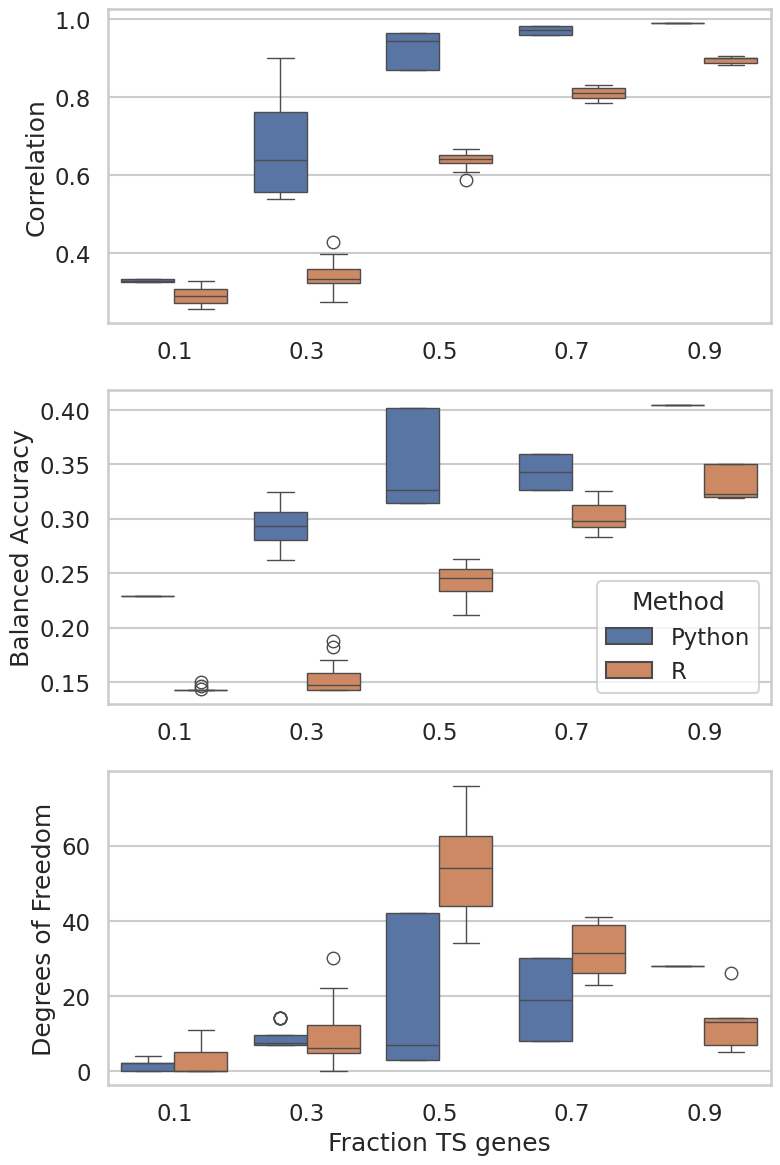

In [11]:
#import tikzplotlib

# combine into one df
results_py_sub = results_py.loc[(results_py.l1_ratio==1) & (results_py.n_batches==1)]
d = {"spearman_corr": np.concatenate([results_py_sub["spearman_corr"].to_numpy(), results_r["cor_spearman"].to_numpy()]),
     "accuracy": np.concatenate([results_py_sub["all_accuracy"].to_numpy(), results_r["bacc"].to_numpy()]),
     "bal_acc": np.concatenate([results_py_sub["all_bal_acc"].to_numpy(), results_r["bacc"].to_numpy()]),
     "dof": np.concatenate([results_py_sub["dof"].to_numpy(), results_r["dof"].to_numpy()]),
     "Method": ["Python"] * results_py_sub.shape[0] + ["R"] * results_r.shape[0],
     "ts": np.concatenate([results_py_sub["ts"], results_r["ts"]]),
     "ss": np.concatenate([results_py_sub["ss"], results_r["ss"]])}
data = pd.DataFrame.from_dict(d)
data.ts.astype("float")
data.ss.astype("float")

fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(8, 12))

sns.boxplot(data=data, y="spearman_corr", x="ts", hue="Method", palette={"Python": python_color, "R": r_color}, ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel("Correlation")
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0, ha='center')
ax1.get_legend().remove()

sns.boxplot(data=data, y="accuracy", x="ts", hue="Method", palette={"Python": python_color, "R": r_color},  ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel("Balanced Accuracy")
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=0, ha='center')

sns.boxplot(data=data, y="dof", x="ts", hue="Method", palette={"Python": python_color, "R": r_color}, ax=ax3)
ax3.set_xlabel('Fraction TS genes')
ax3.set_ylabel("Degrees of Freedom")
ax3.set_xticks(ax3.get_xticks(), ax3.get_xticklabels(), rotation=0, ha='center')
ax3.get_legend().remove()
#ax3.set_yscale("log")

# Display the plot
plt.tight_layout()

fig.savefig("figures/plot_compare_simulations_scpres_presentation.png")

#tikzplotlib_fix_ncols(fig)
#tikzplotlib.save("tikz/plot_compare_simulations.tex")

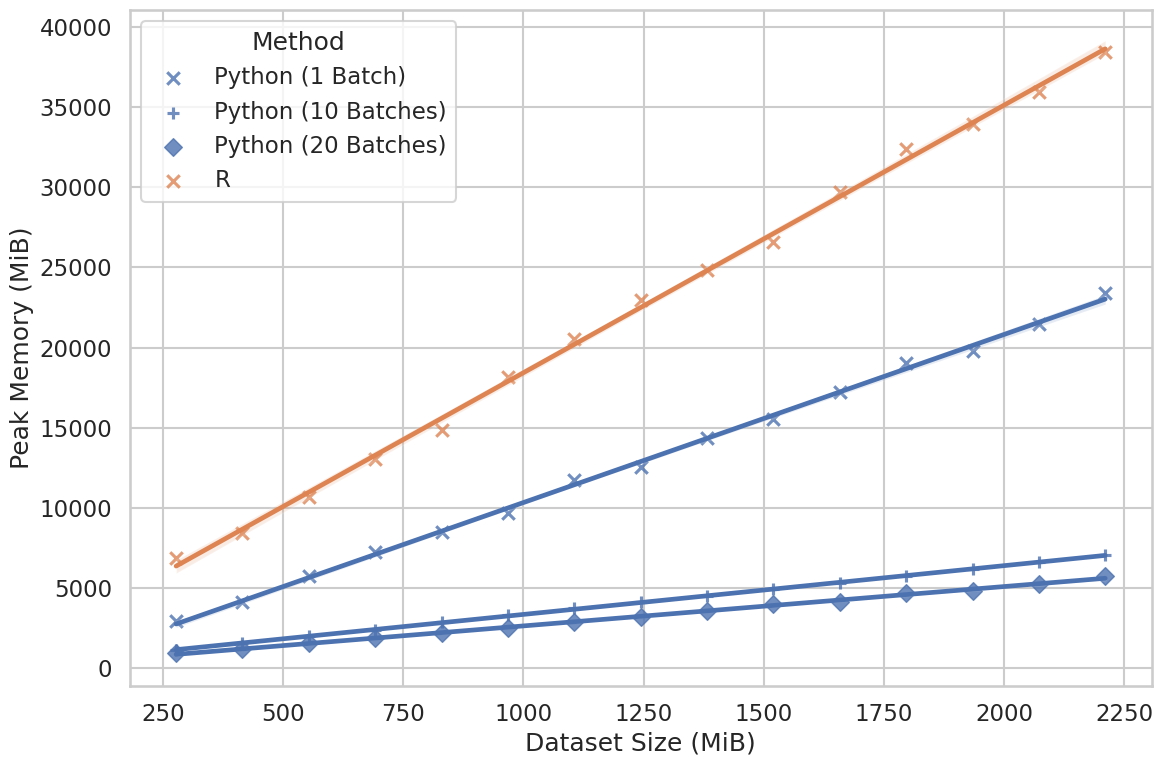

In [30]:
#import tikzplotlib

# combine into one df
results_py_sub = results_py.loc[(results_py.l1_ratio==1) & (results_py.n_batches==1)]
d = {"spearman_corr": np.concatenate([results_py_sub["spearman_corr"].to_numpy(), results_r["cor_spearman"].to_numpy()]),
     "accuracy": np.concatenate([results_py_sub["all_accuracy"].to_numpy(), results_r["bacc"].to_numpy()]),
     "bal_acc": np.concatenate([results_py_sub["all_bal_acc"].to_numpy(), results_r["bacc"].to_numpy()]),
     "dof": np.concatenate([results_py_sub["dof"].to_numpy(), results_r["dof"].to_numpy()]),
     "Method": ["Python"] * results_py_sub.shape[0] + ["R"] * results_r.shape[0],
     "ts": np.concatenate([results_py_sub["ts"], results_r["ts"]]),
     "ss": np.concatenate([results_py_sub["ss"], results_r["ss"]])}
data = pd.DataFrame.from_dict(d)
data.ts.astype("float")
data.ss.astype("float")

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

# Integrate the data from experiment 06: Memory usage
d = pd.read_csv("../06_Profiling/results_filtered.csv")
sns.regplot(data=d[d["Method"] == "Py_1Batch"], x="FileSize", y="MaxRSS", color=python_color, marker="x", label="Python (1 Batch)", ax=ax1)
sns.regplot(data=d[d["Method"] == "Py_10Batches"], x="FileSize", y="MaxRSS", color=python_color, marker="+", label="Python (10 Batches)", ax=ax1)
sns.regplot(data=d[d["Method"] == "Py_20Batches"], x="FileSize", y="MaxRSS", color=python_color, marker="D", label="Python (20 Batches)", ax=ax1)
sns.regplot(data=d[d["Method"] == "R"], x="FileSize", y="MaxRSS", color=r_color, marker="x", label="R", ax=ax1)
ax1.legend(title="Method")
ax1.set_xlabel("Dataset Size (MiB)")
ax1.set_ylabel("Peak Memory (MiB)")

# Display the plot
plt.tight_layout()

fig.savefig("figures/plot_memory_comparison_presentation.png")

#tikzplotlib_fix_ncols(fig)
#tikzplotlib.save("tikz/plot_compare_simulations.tex")

# Python Results
## Scores by n-batches and l1-ratio

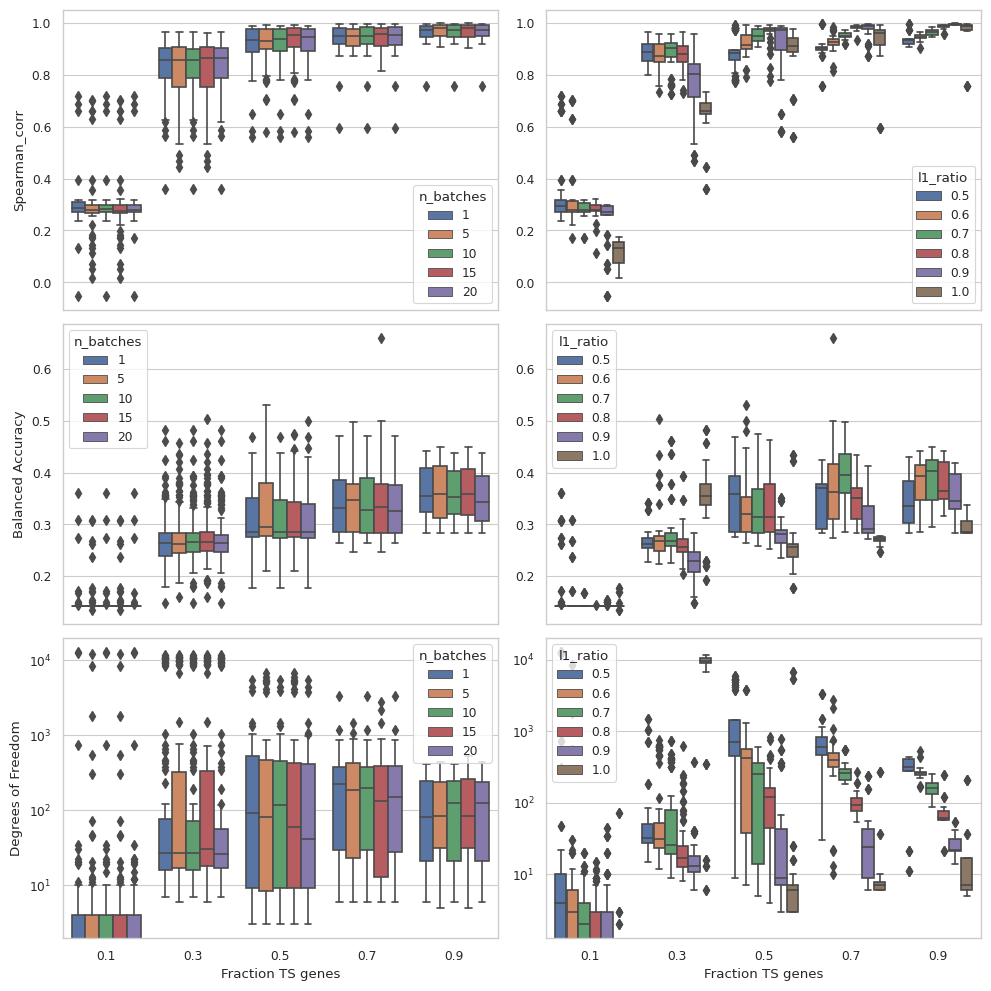

In [30]:
import tikzplotlib

d = results_py.copy()
ts = d['file'].apply(lambda x: re.search(r'_TS(\d+\.\d+)', x).group(1))
ss = d['file'].apply(lambda x: re.search(r'_SS(\d+\.\d+)', x).group(1))
d["ts"] = ts.astype("float")
d["ss"] = ss.astype("float")

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=False)

sns.boxplot(data=d, y="spearman_corr", x="ts", hue="n_batches", ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel("Spearman_corr")
#ax1.get_legend().remove()

sns.boxplot(data=d, y="spearman_corr", x="ts", hue="l1_ratio", ax=ax2)
ax2.set_xlabel("")
ax2.set_ylabel("")
#ax2.get_legend().remove()

sns.boxplot(data=d, y="all_bal_acc", x="ts", hue="n_batches", ax=ax3)
ax3.set_xlabel("")
ax3.set_ylabel("Balanced Accuracy")
#ax3.get_legend().remove()

sns.boxplot(data=d, y="all_bal_acc", x="ts", hue="l1_ratio", ax=ax4)
ax4.set_xlabel("")
ax4.set_ylabel("")
#ax4.get_legend().remove()


sns.boxplot(data=d, y="dof", x="ts", hue="n_batches", ax=ax5)
ax5.set_xlabel('Fraction TS genes')
ax5.set_ylabel("Degrees of Freedom")
ax5.set_xticks(ax5.get_xticks(), ax5.get_xticklabels(), rotation=0, ha='center')
ax5.set_yscale("log")
#ax5.get_legend().remove()


sns.boxplot(data=d, y="dof", x="ts", hue="l1_ratio", ax=ax6)
ax6.set_xlabel("Fraction TS genes")
ax6.set_ylabel("")
ax6.set_xticks(ax6.get_xticks(), ax6.get_xticklabels(), rotation=0, ha='center')
ax6.set_yscale("log")
#ax6.get_legend().remove()

plt.tight_layout()


# external legends -> reduce redundancy, but hard to position
# uncomment the get_legend.remove() lines
#handles_right, labels_right = ax6.get_legend_handles_labels()
#fig.legend(title="L1 Ratio", handles=handles_right, labels=labels_right, loc='upper right', ncols=6, bbox_to_anchor=(0.5, 1.05), frameon=True)

#handles_left, labels_left = ax5.get_legend_handles_labels()
#fig.legend(title="num Batches", handles=handles_left, labels=labels_left, loc='upper left', ncols=5, bbox_to_anchor=(0.71, 1.05), frameon=True)


fig.savefig("figures/plot_score_by_nbatches_and_l1ratio.png")

tikzplotlib_fix_ncols(fig)
tikzplotlib.save("tikz/plot_scores_by_nbatches_and_l1ratio.tex", table_row_sep="\n")

## Scores by SS and TS

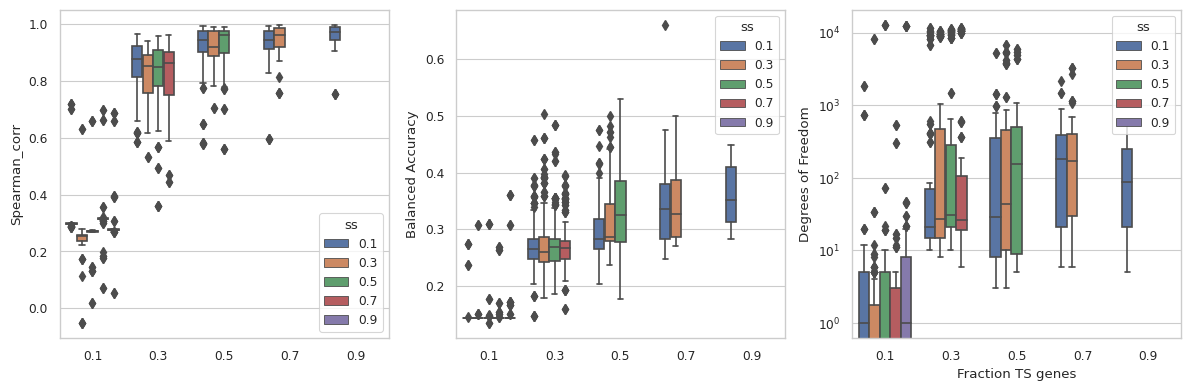

In [33]:
d = results_py.copy()
d["ts"] = d['file'].apply(lambda x: re.search(r'_TS(\d+\.\d+)', x).group(1))
d["ss"] = d['file'].apply(lambda x: re.search(r'_SS(\d+\.\d+)', x).group(1))
d["ts"] = ts.astype("float")
d["ss"] = ss.astype("float")

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))

sns.boxplot(data=d, y="spearman_corr", x="ts", hue="ss", ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel("Spearman_corr")
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0, ha='center')

sns.boxplot(data=d, y="all_bal_acc", x="ts", hue="ss", ax=ax2)
ax2.set_xlabel("")
ax2.set_ylabel("Balanced Accuracy")
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=0, ha='center')

sns.boxplot(data=d, y="dof", x="ts", hue="ss", ax=ax3)
ax3.set_xlabel('Fraction TS genes')
ax3.set_ylabel("Degrees of Freedom")
ax3.set_xticks(ax3.get_xticks(), ax3.get_xticklabels(), rotation=0, ha='center')
ax3.set_yscale("log")

# Display the plot
plt.tight_layout()

fig.savefig("figures/plot_scores_by_ss_and_ts.png")


# Gene Selection

In [9]:
import os

genes_py = []
weights_py = []
genes_r = []

for gene_file in filter(lambda f: f.startswith("genes_py"), os.listdir("results")):
    with open(os.path.join("results", gene_file), "r") as f:
        for i, line in enumerate(f):
            if i % 2 == 1:
                gs = line.strip().split(", ")
                
                # if line is of length zero, split returns [""]
                if len(gs) == 1 and gs[0] == "":
                    weights_py.append([])
                else:
                    weights_py.append([float(w) for w in gs])
                    
            if i % 2 == 0:
                gs = line.strip().split(", ")
                
                # if line is of length zero, split returns [""]
                if len(gs) == 1 and gs[0] == "":
                    genes_py.append([])
                else:
                    genes_py.append(gs)

#r_sep = ", "
r_sep = " "
with open("results/genes_R.txt", "r") as f:
    for line in f:
        gs = line.strip().split(r_sep)
        
        # if line is of length zero, split returns [""]
        if len(gs) == 1 and gs[0] == "":
            genes_r.append([])
        else:
            # FIX: Replace "." in gene names: 
            # This change was made in psupertime 
            # and causes issues when comparig
            gs = [g.replace(".", "-") for g in gs]
            genes_r.append(gs)


## Scoring of Sets

In [10]:
# dice index for two Set objects s1, s2
dice = lambda s1, s2:  ( 2 * len(s1.intersection(s2)) ) / ( len(s1) + len(s2) )

# jaccard score for two Set objects s1, s2
jaccard = lambda s1, s2: (len(s1.intersection(s2))) / (len(s1.union(s2)))

# overlap coefficient for Sets s1, s2
overlap = lambda s1, s2: (len(s1.intersection(s2)) / np.min([len(s1), len(s2)]))

## Consistancy of Gene Selection for different seeds

Calculates the Jaccard Score and Dice index for all pairs of experiments grouped by the TS value.

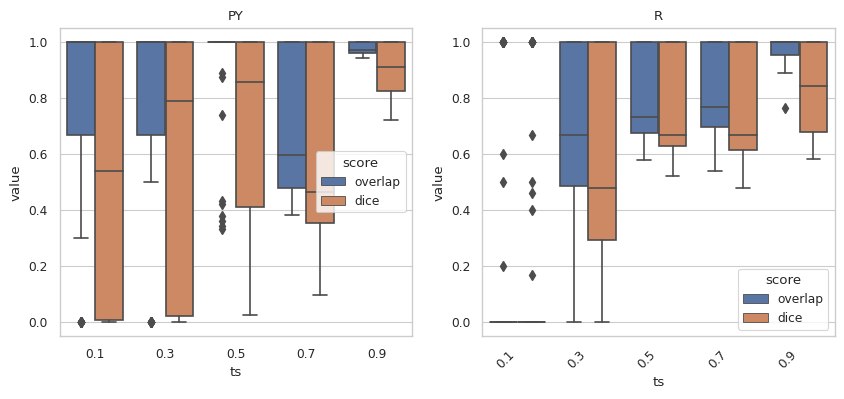

In [35]:
import seaborn as sns

n_seeds = 5

d = {"overlap": [], "dice": [], "ts": [], "l1_ratio": [], "n_batches": []}
for i in range(0, len(genes_py), n_seeds):
    for j in range(n_seeds):
        for k in range(j, n_seeds):
            s1 = set(genes_py[i + j])
            s2 = set(genes_py[i + k])
            
            if len(s1) > 0 and len(s2) > 0:
                d["overlap"] += [overlap(s1, s2)]
                d["dice"] += [dice(s1, s2)]
            else:
                d["overlap"] += [0]
                d["dice"] += [0]
                
            d["ts"] += [results_py["ts"].iloc[i]]
            d["n_batches"] += [results_py["n_batches"].iloc[i]]
            d["l1_ratio"] += [results_py["l1_ratio"].iloc[i]]


data_py = pd.DataFrame.from_dict(d)
# limit
data_py = data_py[(data_py.l1_ratio == 1) & (data_py.n_batches == 1)]

d = {"overlap": [], "dice": [], "ts": []}
for i in range(0, len(genes_r), n_seeds):
    for j in range(n_seeds):
        for k in range(j, n_seeds):
            s1 = set(genes_r[i + j])
            s2 = set(genes_r[i + k])
            
            if len(s1) > 0 and len(s2) > 0:
                d["overlap"] += [overlap(s1, s2)]
                d["dice"] += [dice(s1, s2)]
            else:
                d["overlap"] += [0]
                d["dice"] += [0]
                
            d["ts"] += [np.array(results_r["ts"])[i]]

data_r = pd.DataFrame.from_dict(d)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))

# Title "Set Stability by value of TS over all Experiments for Genes called by R and Py"
_ = sns.boxplot(data=data_py.melt(id_vars="ts", value_vars=["overlap", "dice"], var_name="score"), x="ts", y="value", hue="score", ax=ax1)
_ = ax1.set_title("PY")


_ = sns.boxplot(data=data_r.melt(id_vars="ts",  value_vars=["overlap", "dice"], var_name="score"), x="ts", y="value", hue="score", ax=ax2)
_ = ax2.set_title("R")
_ = ax2.set_xticklabels([t.get_text() for t in ax2.get_xticklabels()], rotation=45, ha="right")

fig.savefig("figures/plot_gene_set_consistancy_over_seeds.png")

# Gene Selection R vs Python

In [16]:
idx = (results_py.l1_ratio == 1) & (results_py.n_batches == 1)
genes_py_sub = []
for i, e in enumerate(idx):
    if e:
        genes_py_sub.append(genes_py[i])

In [17]:
from sklearn import metrics

gene_metrics_dict = {"overlap": [], "dice": [], "jaccard": [], "n_genes_py": [], "n_genes_r": []}
# ISSUE: different sorting of genes_py and genes_r
# ISSUE: comparing seed vs. seed maybe meaningless. 
#   For each setting: compare all seeds pairwise, report best scores?
#   OR: For each settings: report all pairwise scores betwee seeds?
for i, (ex1, ex2) in enumerate(zip(genes_py_sub, genes_r)):
    s1, s2 = set(ex1), set(ex2)

    if len(s1) > 0 and len(s2) > 0:
        # dice simmilarity coefficient
        dsc = dice(s1, s2)

        # jaccard score 
        jac = jaccard(s1, s2)

        # overlap coefficient
        ovl = len(s1.intersection(s2)) / np.min([len(s1), len(s2)])
    else:
        dsc, jac, ovl = 0, 0, 0

    gene_metrics_dict["n_genes_py"] += [len(s1)]
    gene_metrics_dict["n_genes_r"] += [len(s2)]
    gene_metrics_dict["overlap"] += [ovl]
    gene_metrics_dict["dice"] += [dsc]
    gene_metrics_dict["jaccard"] += [jac]

    #print("[%s]:" % i, "overlap:", ovl, "Dice:", dsc, "Jaccard:", jac

gene_metrics = pd.DataFrame.from_dict(gene_metrics_dict)

gene_metrics["ts"] = results_py_sub.ts.to_numpy()
gene_metrics["ss"] = results_py_sub.ss.to_numpy()

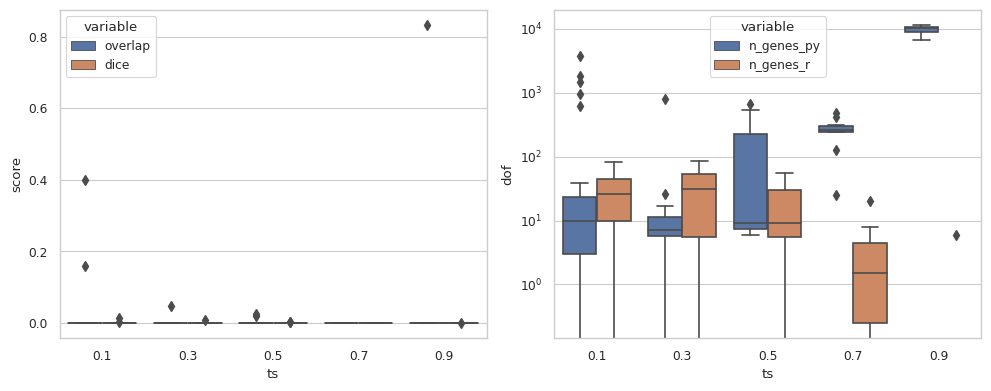

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))

# TITLE = "Set Stability Statistics between R and Py"
_ = sns.boxplot(gene_metrics.melt(id_vars="ts", value_vars=["overlap", "dice"], value_name="score"), x="ts", y="score", hue="variable", ax=ax1)
_ = sns.boxplot(gene_metrics.melt(id_vars="ts", value_vars=["n_genes_py", "n_genes_r"], value_name="dof"), x="ts", y="dof", hue="variable", ax=ax2)
_ = ax2.set_yscale("log")
fig.tight_layout()

## Closer look at simulations with little overlap

In [25]:
import scanpy as sc
import os

# the exact experiment of interest
idx = 74

# Union and intersect of the identified genes
union = list(set(genes_py[idx]).union(set(genes_r[idx])))
intersect = list(set(genes_py[idx]).intersection(set(genes_r[idx])))

data_dir = "/home/julian/Uni/MasterThesis/data/"
simdata = sc.read_h5ad(os.path.join(data_dir, results_py.iloc[idx].file))

counts = simdata[:,union].copy()

# Add a column indicating from which tool a gene was called
counts.var["group"] = None
counts.var.loc[genes_py[idx], "group"] = "PY"
counts.var.loc[genes_r[idx], "group"] = "R"
counts.var.loc[intersect, "group"] = "PY,R"

file = results_py.iloc[idx]["file"]
print("Sim='%s'" % file, "Idx=%s" % idx, "TS=%s" % ts[idx], "SS=%s" % ss[idx])
print("\nPY:")
print(results_py.iloc[idx][["dof", "train_bal_acc", "test_bal_acc", "spearman_corr"]])
print("\nR:")
print(results_r.iloc[idx][["dof", "bacc", "cor_spearman"]])

KeyError: 74

/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


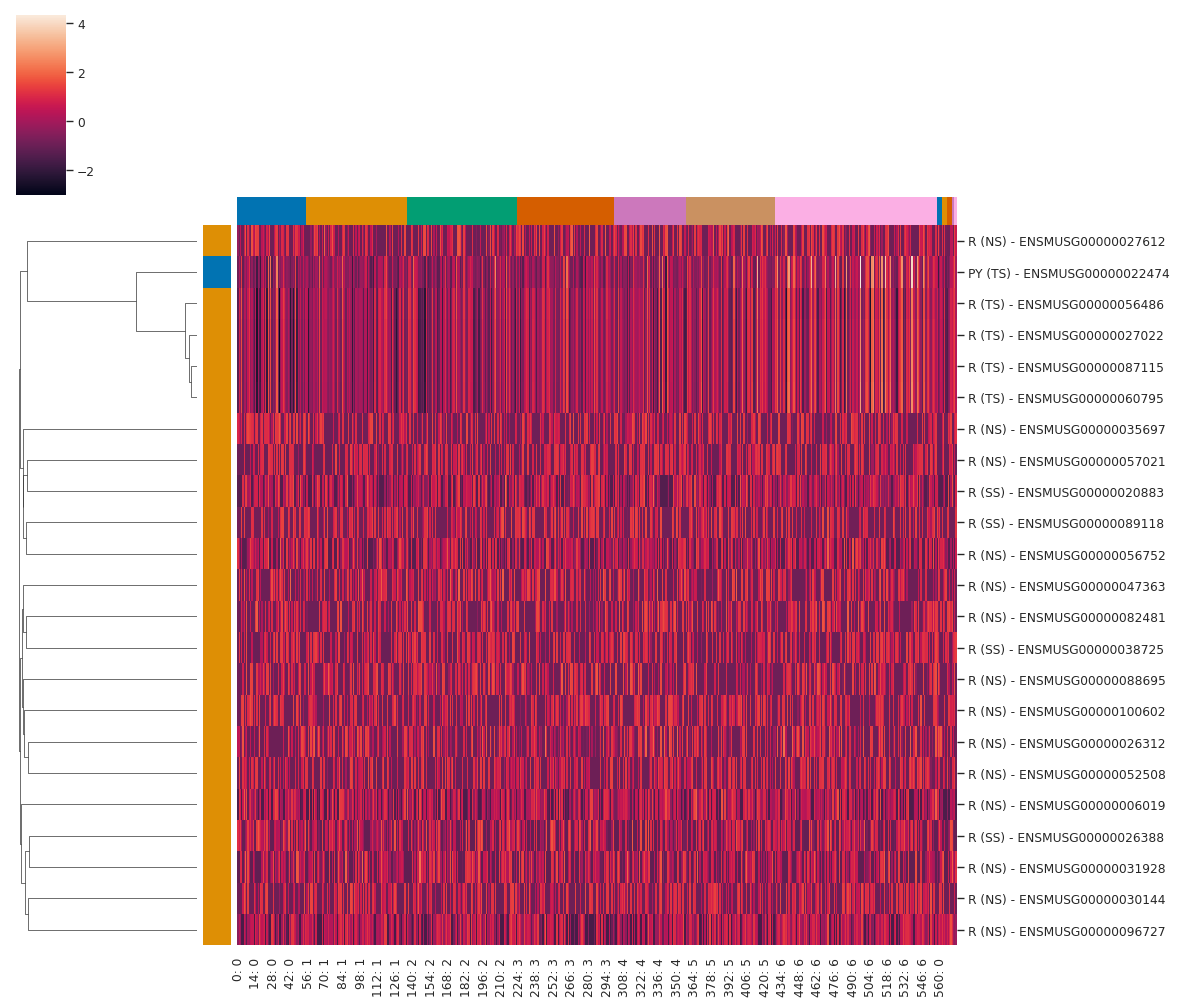

In [27]:
from scipy.spatial import distance
from scipy.cluster import hierarchy
import seaborn as sns

col_labels = counts.obs.Ordinal_Time_Labels.to_numpy()
cmap = sns.color_palette("colorblind", max(3, len(np.unique(col_labels))))

col_colors = [cmap[e] for e in col_labels]
row_colors = [cmap[0 if e == "PY" else 1 if e == "R" else 2] for e in counts.var["group"].to_numpy()]

g = sns.clustermap(counts.X.T, col_cluster=False, col_colors=col_colors, row_colors=row_colors)
ordering = g.dendrogram_row.reordered_ind

ylabels = []
# iterate only over the ticks that are plotted!
for text in g.ax_heatmap.get_yticklabels():
    # the Text() object contains the row index as a string
    i = int(text.get_text())
    group = counts.var.iloc[i].group
    setting = counts.var.iloc[i].Setting
    gene_name = counts.var.iloc[i].name
    label = "%s (%s) - %s" % (group, setting, gene_name)
    ylabels.append(label)
g.ax_heatmap.set_yticklabels(ylabels, rotation=0)

xlabels = []
# iterate only over the ticks that are plotted!
for text in g.ax_heatmap.get_xticklabels():
    # the Text() object contains the row index as a string
    i = int(text.get_text())
    time_label = counts.obs.iloc[i].Ordinal_Time_Labels
    label = "%s: %s" % (i, time_label)
    xlabels.append(label)
g.ax_heatmap.set_xticklabels(xlabels, rotation=90)

# Display the plot
plt.show()

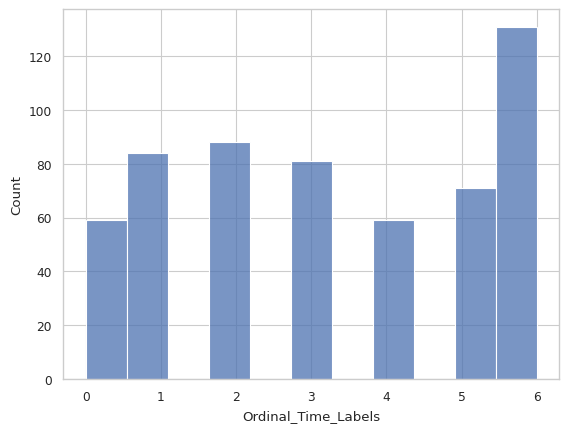

In [28]:
h = sns.histplot(simdata.obs.Ordinal_Time_Labels)

## Inspect clustered gene expression

         Falling back to preprocessing with `sc.pp.pca` and default params.


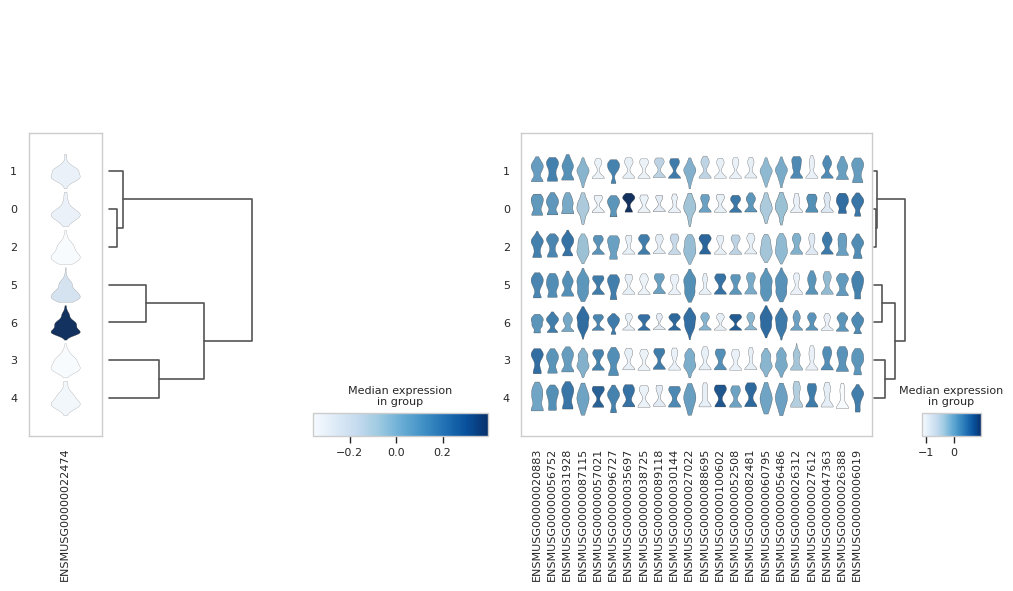

In [26]:
import scanpy as sc

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

simdata.obs["categorical_labels"] = simdata.obs.Ordinal_Time_Labels.astype("category")
markers = genes_py[idx]
_ = sc.pl.stacked_violin(simdata, markers, show=False, groupby="categorical_labels", dendrogram=True, ax=ax1)

markers = genes_r[idx]
_ = sc.pl.stacked_violin(simdata, markers, show=False, groupby="categorical_labels", dendrogram=True, ax=ax2)

plt.tight_layout()
plt.show()